# **Nonlinear Optimization 2024.2**

### **Optimum power for a set of $m$ lamps iluminating a set of $n$ flat patches to best approach a target illumination**

Consider $m$ lamps illuminating $n$ (small flat) patches. The illumination intensity $I_k$ at the $k$-th patch depends linearly on the lamp power $p_j$ as:

\begin{equation*}
    I_k = \displaystyle \sum_{j=1}^{m}a_{k,j}p_j, \quad \text{with} \quad a_{k,j} = r_{k,j}^{-2}\max\{cos(\theta_{k.,j}),0\},
\end{equation*}

where $r_{k,j}$ is the length of the vector $r_{k,j}$ connecting the center of the $k$-th patch to the position of the $m$-th lamp and $\theta_{k,j}$ is the angle between the patch normal vector $\mathbf{n}_k$ and $\mathbf{r}_{k,j}$. See the Convex Optimization book slides for more details.

The proposed problem is to achieve a desired illumination $I_{des}$ with bounded lamp powers ($p_{max}$), i.e.,

\begin{align*}
    & \min \underset{k=1,2,\dots,n}{\max}\vert \log{(I_k)} - \log{(I_{des})} \vert \\
    \text{s. t.}\quad & 0 \leq p_j \leq p_{max}, j = 1, 2, \dots, m.
\end{align*}

#### **Suboptimally solve the problem using, e.g., Python or Octave, according to the following approaches:**

1. Using uniform power, i.e., $p_j = p, 0 \leq p \leq p_{max}$.
2. Using least-squares, i.e., $\min . \displaystyle \sum_{k=1}^{n} (I_k - I_{des})^2$, and rounding $p_j$ as $p_j = \max\{0, \min\{p_j, p_{max}\}\}$.
3. Using weighted least-squares, i.e., $\min . \displaystyle \sum_{k=1}^{n}(I_k - I_{des})^2 + w_j\sum_{j=1}^n (p_j - p_{max})^2$ and iteratively adjusting the weights $w_j$ until $0 \leq p \leq p_{max}, \forall j$.
4. Using linear programming, i.e., 

\begin{align*}
    & \min . \underset{k=1, 2, \dots, n}{\max} \vert I_{k} - I_{des} \vert \\
    \text{s. t.} \quad & 0 \leq p_j \leq p_{max}, j = 1, 2, \dots, m.
\end{align*}

#### **Solve the problem optimally using convex optimization**

For this goal, consider the equivalent convex problem

\begin{align*}
    & \min . \underset{k = 1, 2, \dots, n}{\max} h\left(\cfrac{I_k}{I_{des}}\right) \\
    \text{s. t.} \quad & 0 \leq p_j \leq p_{max}, j = 1, 2, \dots, m, 
\end{align*}

where $h(u) = \max\left\{u, \cfrac{1}{u}\right\}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

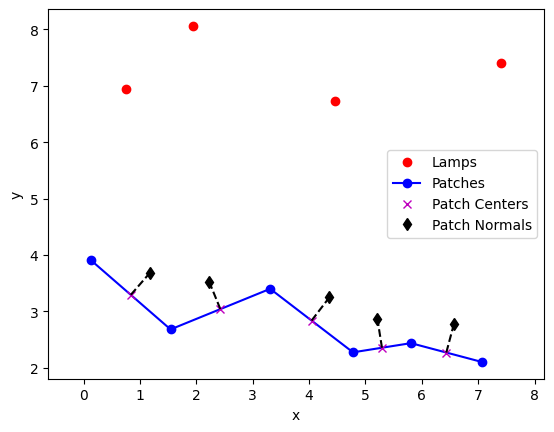

In [2]:
showFig = True
numLamps = 4            # number of lamps
numPatches = 5          # number of patches
maxPwr = 1              # maximum power
desiredillum = 0.01     # desired illumination

# Define lamp and patch positions
lampPos = np.array([
    [0.7609, 6.9497],
    [1.9382, 8.0610],
    [4.4674, 6.7316],
    [7.4095, 7.3987]
])

patchPos = np.array([
    [0.1329, 3.9041],
    [1.5435, 2.6782],
    [3.3102, 3.3981],
    [4.7796, 2.2716],
    [5.8071, 2.4345],
    [7.0621, 2.1015]
])

lampPos = lampPos[:, 0] + 1j * lampPos[:, 1]
patchPos = patchPos[:, 0] + 1j * patchPos[:, 1]
patchCenter = (patchPos[:-1] + patchPos[1:]) / 2
patchNorm = patchPos[1:] - patchPos[:-1]
minPatchLength = np.min(np.abs(patchNorm)) / 2

for p in range(len(patchNorm)):
    n = np.linalg.svd(np.array([[np.real(patchNorm[p]), np.imag(patchNorm[p])]]).T)[0][:, 1]
    patchNorm[p] = minPatchLength * (n[0] + 1j * n[1])

if showFig:
    plt.plot(np.real(lampPos), np.imag(lampPos), 'ro', markerfacecolor='auto', label='Lamps')
    plt.plot(np.real(patchPos), np.imag(patchPos), 'bo-', markerfacecolor='auto', label='Patches')
    plt.plot(np.real(patchCenter), np.imag(patchCenter), 'mx', markerfacecolor='auto', label='Patch Centers')
    plt.plot(np.real(patchNorm + patchCenter), np.imag(patchNorm + patchCenter), 'kd', markerfacecolor='auto', label='Patch Normals')
    
    for i in range(len(patchCenter)):
        plt.plot([np.real(patchCenter[i]), np.real(patchNorm[i] + patchCenter[i])],
                 [np.imag(patchCenter[i]), np.imag(patchNorm[i] + patchCenter[i])], 'k--')
    
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

radDist = np.zeros((len(patchCenter), len(lampPos)))
angShift = np.zeros((len(patchCenter), len(lampPos)))

for i in range(len(patchCenter)):
    for j in range(len(lampPos)):
        radDist[i, j] = np.abs(patchCenter[i] - lampPos[j])
        angShift[i, j] = np.angle(lampPos[j] - patchCenter[i]) - np.angle(patchNorm[i])

illumCoeff = radDist ** (-2) * np.maximum(np.cos(angShift), 0)


## **Suboptimal Approaches**

### **1. Uniform power**

$p_j = p, 0 \leq p \leq p_{max}$


In [3]:
illumCoeff

array([[0.05531853, 0.03684644, 0.03980099, 0.01592419],
       [0.05531634, 0.03762615, 0.03527592, 0.00743384],
       [0.00868682, 0.01601822, 0.05562495, 0.03109943],
       [0.01951462, 0.0212331 , 0.05034646, 0.02840137],
       [0.00771319, 0.01127429, 0.03282549, 0.03657036]])

In [4]:
np.sum(illumCoeff*0, axis=1)

array([0., 0., 0., 0., 0.])

In [5]:
sum([0.01592419, 0.00743384, 0.031009943, 0.02840137, 0.03657036])

0.119339703

In [6]:
np.sum(illumCoeff, axis=1)

array([0.14789014, 0.13565225, 0.11142941, 0.11949556, 0.08838332])

In [7]:
P = np.arange(0, 0.15, 0.15/100)
currillum = np.zeros((len(P), numPatches))

for i in range(0, len(P)):
    for k in range(numPatches):
        currillum[i,:] = np.sum(illumCoeff*P[i], axis=1)

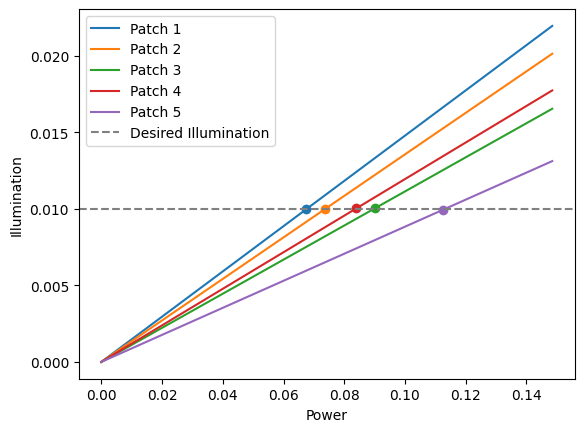

In [8]:
for i in range(5):
    plt.plot(P, currillum[:,i], label=f'Patch {i+1}')
    
    idx = np.where(np.isclose(currillum[:, i], desiredillum, atol=6e-5))[0]

    plt.scatter(P[idx], currillum[idx, i], marker='o')

plt.axhline(y=desiredillum, color='gray', linestyle='--', linewidth=1.5, label='Desired Illumination')

plt.xlabel('Power')
plt.ylabel('Illumination')
plt.legend()

plt.show()

### **2. Least Squares**

$$
    \min . \displaystyle \sum_{k=1}^{n} (I_k - I_{des})^2
$$

$$
    p_j = \max\{0, \min\{p_j, p_{max}\}\}
$$

$$
    I_k = \displaystyle \sum_{j=1}^{m}a_{k,j}p_j = \displaystyle \sum_{j=1}^{m} r_{k,j}^{-2}\max\{cos(\theta_{k.,j}),0\} p_j
$$

\begin{align*}
    & \min \sum_{k=1}^n \left( I_k - I_{des} \right)^2 \\
    = & \min \sum_{k=1}^n \left( \displaystyle \sum_{j=1}^{m}a_{k,j}p_j - I_{des} \right)^2
\end{align*}

$$
    \min \sum_{k=1}^{n} \left( a_{k1}p_1 + a_{k2}p_2 + a_{k3}p_3 + a_{k4}p_4 + a_{k1}p_5 - I_{des} \right)^2
$$

$$
    \min \sum_{k=1}^n 
    \left(
    \begin{bmatrix}
        a_{k1} \\
        a_{k2} \\
        a_{k3} \\
        a_{k4} \\
        a_{k5}
    \end{bmatrix}
    \begin{bmatrix}
        p_1 & p_2 & p_3 & p_4 & p_5
    \end{bmatrix}
    - I_{des}
    \right)^2
$$

In [29]:
illumCoeff_T = illumCoeff.T
y = np.full(5, desiredillum)
p_opt = np.linalg.inv(illumCoeff_T @ illumCoeff) @ illumCoeff_T @ y

In [30]:
p_opt

array([-0.39888698,  0.94358396, -0.1430944 ,  0.19224969])

In [25]:
y

array([0.01, 0.01, 0.01, 0.01])

### **3. Weighted Least Squares**

For a diagonal weight matrix $W$:

$$
    (X^T W X) \hat{\beta} = X^T W y \quad \therefore \quad \hat{\beta} = (X^T W X)^{-1} X^T W y
$$